# Single shot detection (SSD)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json, pdb
from matplotlib import patches, patheffects

In [3]:
torch.backends.cudnn.benchmark = True

## Dataset

In [4]:
PATH = Path('data/pascal_voc/')
trn_json = json.load((PATH/'pascal_train2007.json').open())

In [5]:
IMAGES,ANNOTATIONS,CATEGORIES = 'images', 'annotations', 'categories'
FN, ID, IMG_ID, CAT_ID, BBOX, NAME = 'file_name', 'id', 'image_id', 'category_id', 'bbox', 'name'

In [6]:
cats = dict((o[ID], o[NAME]) for o in trn_json[CATEGORIES])

In [7]:
train_fn = dict((o[ID], o[FN]) for o in trn_json[IMAGES])

In [8]:
train_ids = [o[ID] for o in trn_json[IMAGES]]

In [9]:
JPEGS = 'VOC2007/JPEGImages'

In [10]:
IMPATH = PATH/JPEGS

In [11]:
def convert_bb_to_np(bb):
    return np.array([bb[1], bb[0], bb[1] + bb[3] - 1, bb[0] + bb[2] - 1])

def convert_bb_to_VOC(bb):
    return np.array([bb[1], bb[0], bb[3]-bb[1] + 1, bb[2]-bb[0] + 1])

In [12]:
def get_train_annot():
    train_annotations = collections.defaultdict(lambda: [])
    for o in trn_json[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = convert_bb_to_np(bb)
            train_annotations[o[IMG_ID]].append((bb, o[CAT_ID]))
    return train_annotations

In [13]:
train_annot = get_train_annot()

**Convenience functions for plotting:**

In [14]:
def show_img(img, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img),
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [15]:
def draw_outline(matplt_plot_obj, lw):    matplt_plot_obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [16]:
def draw_rect(ax, bbox, color='white'):
    patch = ax.add_patch(patches.Rectangle(bbox[:2], *bbox[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [17]:
def draw_text(ax, xy, text, sz=14, color='white'):
    pass
    txt = ax.text(*xy, text, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(txt, 1)

In [18]:
def draw_image(im, annot):
    ax = show_img(im, figsize=(16, 8))
    for bbox, cat in annot:
        bb = convert_bb_to_VOC(bbox)
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cats[cat], sz=16)
        
def draw_idx(i):
    im_annot = train_annot[i]
    im = open_image(IMPATH/train_fn[i])
    draw_image(im, im_annot)

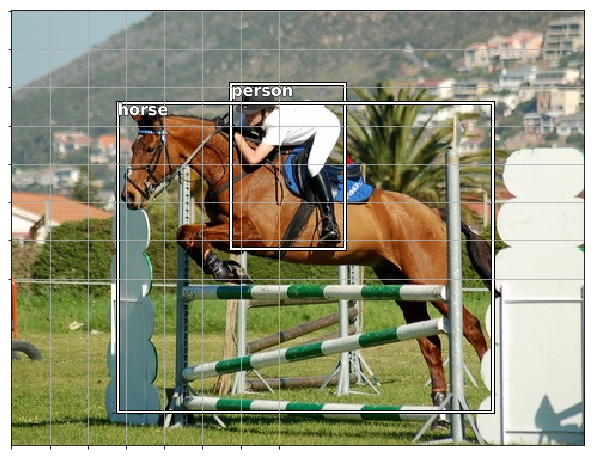

In [19]:
draw_idx(17)

## Step 1: Multi label classification

In [20]:
MULTI_CLASS_CSV = PATH/'tmp/multi_class.csv'

In [21]:
train_annot[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

Use a set because we only want the label once, not for every person in an image for instance.

In [22]:
multi_labels = [set([cats[p[1]] for p in train_annot[i]]) for i in train_ids]

In [23]:
multi_labels_string = [' '.join(str(p) for p in o) for o in multi_labels]

In [24]:
df = pd.DataFrame({'fn': [train_fn[o] for o in train_ids], 'clas': multi_labels_string}, columns=['fn', 'clas'])

In [25]:
df.head(2)

,fn,clas
0,000012.jpg,car
1,000017.jpg,horse person


In [26]:
df.to_csv(MULTI_CLASS_CSV, index=False)

In [27]:
model = resnet34
sz = 224
bs = 64

In [28]:
tfms = tfms_from_model(model, sz, crop_type=CropType.NO)

In [29]:
modeldata = ImageClassifierData.from_csv(PATH, JPEGS, MULTI_CLASS_CSV, tfms=tfms)

In [30]:
learn = ConvLearner.pretrained(model, modeldata)

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [31]:
learn.opt_fn = optim.Adam

In [ ]:
learn.lr_find(start_lr=1e-5, end_lr=100)

In [ ]:
learn.sched.plot()

In [ ]:
lr = 2e-2

In [ ]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

In [ ]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=1, use_clr=(32,5))

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find(lrs/1000)

In [ ]:
learn.sched.plot(n_skip_end=9)

In [ ]:
learn.fit(lrs=lrs/10, n_cycle=1, cycle_len=5, use_clr=(32,5))

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('multi_class')

In [ ]:
learn.load('multi_class')

In [ ]:
y = learn.predict()
x, _ = next(iter(modeldata.val_dl))

In [ ]:
x = to_np(x)

In [ ]:
x.shape, y.shape

In [ ]:
figure, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = modeldata.val_ds.denorm(x)[i]
    yy = np.nonzero(y[i]>0.4)[0]
    lbl = '\n'.join(modeldata.classes[o] for o in yy)
    ax = show_img(img, ax=ax)
    draw_text(ax, (0,0), lbl)
plt.tight_layout()

## Bbox per anchor box

In the notebook "Object detection" we produced an output vector with length $(4 + n_{cats})$ to predict the 4 coordinates of a bounding box and the category of the largest object.

How would we do it if we wanted to predict for example 16 objects with bounding boxes and categories?

1. option: `nn.Linear(n_inp, 16*(4 + n_cats))` which is called Yolo architecture
2. option: use `nn.Conv2d` with `stride=2` to produce an output tensor of the shape (4, 4, 4 + n_cats) which is called SSD architecture.

Look at **receptive field** (lesson 8, min ~38). Keep in mind that the **center** of the receptive field of an activation **has more dependencies**.

### 1. Step: Set up data

In [ ]:
CLASS_CSV = PATH/'tmp/class.csv'
MULTIBBOX_CSV = PATH/'tmp/mbb.csv'

In [ ]:
model = resnet34
sz = 224
bs = 64

In [ ]:
# for every image a list of the included classes
# pay attention:
# multi_class[i] belongs to train_ids[i]
multi_class = [[cats[p[1]] for p in train_annot[o]] for o in train_ids]

In [ ]:
id2cat = list(cats.values())

Reduces every id by 1 with respect to `cats`. *Aeroplane* was 1, now its key=0.

In [ ]:
cat2id = {v: k for k, v in enumerate(id2cat)}

In [ ]:
multi_class_id = np.array([np.array([cat2id[p] for p in o]) for o in multi_class])

In [ ]:
multi_class[:2], multi_class_id[:2]

In [ ]:
id2cat[6], id2cat[14], id2cat[12]

For index i `train_ids[i]` returns the id of the image, `multi_class[i]` the classes of the contained objects in form of words and `multi_class_id[id]` the classes in form of indices.

**Validation set:**

In [ ]:
val_idxs = get_cv_idxs(len(train_fn))

Split `multi_class_id` into train and validation set:

In [ ]:
((val_multi_class_id, trn_multi_class_id),) = split_by_idx(val_idxs, multi_class_id)

In [ ]:
len(val_multi_class_id), len(trn_multi_class_id)

For every image, simply concatenate the coordinates of all bounding boxes together. We do this because we can join them to a string and later use the fastai `ImageClassifierData.from_csv`.

In [ ]:
multi_bbox = [np.concatenate([p[0] for p in train_annot[o]]) for o in train_ids]

multi_bbox_str = [' '.join(str(p) for p in o) for o in multi_bbox]

In [ ]:
df = pd.DataFrame({'fn': [train_fn[i] for i in train_ids], 'bbox': multi_bbox_str}, columns=['fn', 'bbox'])
df.to_csv(MULTIBBOX_CSV, index=False)

**Check the dataframe contains the right things:**

In [ ]:
train_fn[12]

In [ ]:
multi_bbox[0]

In [ ]:
train_annot[12], train_fn[12]

In [ ]:
df.head(2)

In [ ]:
aug_tfms = [
    RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
    RandomFlip(tfm_y=TfmType.COORD)
]

In [ ]:
tfms = tfms_from_model(model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)

`continuous=True` because we regress the bounding box coordinates.

In [ ]:
modeldata = ImageClassifierData.from_csv(PATH, JPEGS, MULTIBBOX_CSV, tfms=tfms, val_idxs=val_idxs, continuous=True, num_workers=4)

#### Concatenate the two datasets: categories and bounding boxes

In [ ]:
class ConcatLabelBBoxDataset(Dataset):
    def __init__(self, ds, lbl2):
        self.ds, self.lbl2 = ds, lbl2
        self.sz = ds.sz

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        y2 = self.lbl2[i]
        return (x, (y, y2))

In [ ]:
trn_ds2 = ConcatLabelBBoxDataset(modeldata.trn_ds, trn_multi_class_id)

val_ds2 = ConcatLabelBBoxDataset(modeldata.val_ds, val_multi_class_id)

**Replace the dataset with the combined dataset containing both the bounding boxes and the categories.**

In [ ]:
modeldata.trn_dl.dataset = trn_ds2
modeldata.val_dl.dataset = val_ds2

#### Let's take a look at the return values of the dataloaders to check everything is right!

In [ ]:
x, y = next(iter(modeldata.val_dl))
x = x.data.cpu().numpy()
x = modeldata.val_ds.ds.denorm(x)

In [ ]:
x, y = next(iter(modeldata.trn_dl))
x = x.data.cpu().numpy()
x = modeldata.val_ds.ds.denorm(x)

In [ ]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    '''Return N different RGBA colors'''
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colors = 12
cmap = get_cmap(num_colors)
color_list = [cmap(float(x)) for x in range(num_colors)]

In [ ]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [convert_bb_to_VOC(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if(c != 0 and (b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=color_list[i%num_colors])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=color_list[i%num_colors])

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### 2. Step: Build an architecture

In [ ]:
k = 1

In [ ]:
n_classes = len(id2cat) + 1  # for 'background'
n_activations = k * (4 + n_classes)  # for bbox coordinates + classes

class StandardConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super(). __init__()
        self.k = k
        
        # Prediction of classes
        self.oconv1 = nn.Conv2d(n_in, n_classes * k, kernel_size=3, padding=1)
        
        # Prediction of bbox coordinates
        self.oconv2 = nn.Conv2d(n_in, 4 * k, kernel_size=3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
               flatten_conv(self.oconv2(x), self.k)]

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StandardConv(512, 256, stride=1)  # keeps size the same because of padding
        self.sconv1 = StandardConv(256, 256)  # reduces size by factor of 2 because of stride=2
        self.out = OutConv(k, 256, bias)
    
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

In [ ]:
custom_head = SSD_Head(k, -3.)
new_model = ConvnetBuilder(model, 0, 0, 0, 0, custom_head=custom_head)

learn = ConvLearner(modeldata, new_model)
learn.opt_fn = optim.Adam

In [ ]:
x, y = next(iter(modeldata.val_dl))
x, y = V(x), V(y)

In [ ]:
learn.model.eval()

In [ ]:
batch = learn.model(x)

In [ ]:
predicted_classes, predicted_bboxes = batch

**Output shapes:**

In [ ]:
predicted_classes.size(), predicted_bboxes.size()

### 3. Step: Define a custom loss function - Matching problem

1. Match the ground truth bounding boxes in the image to (at least) one of the default boxes by calculating the *Jaccard index* (area of overlap / area of union).
1. Each default box is responsible to predict the category of the object in the box (its receptive field) and the offset of the ground truth bounding box to the default box.

In [ ]:
anc_grid = 4

anc_offset = 1/(anc_grid * 2)
anc_x = np.repeat(np.linspace(start=anc_offset, stop=1-anc_offset, num=anc_grid), anc_grid)

anc_y = np.tile(np.linspace(start=anc_offset, stop=1-anc_offset, num=anc_grid), anc_grid)

In [ ]:
anc_centers = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))

In [ ]:
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])

In [ ]:
anchors = V(np.concatenate([anc_centers, anc_sizes], axis=1), requires_grad=False).float()

In [ ]:
anchors

In [ ]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [ ]:
grid_sizes

#### Center of the *default boxes*

In [ ]:
plt.scatter(anc_x, anc_y, )
plt.xlim(0, 1)
plt.ylim(0, 1)

#### Convert *center and size* to *corners*:

In [ ]:
def hw2corners(center, hw):
    return torch.cat([center-hw/2, center+hw/2], dim=1)

In [ ]:
anchor_corners = hw2corners(anchors[:, :2], anchors[:, 2:])

In [ ]:
plt.scatter(anchor_corners[:, 2], anchor_corners[:, 3])
plt.scatter(anchor_corners[:, 0], anchor_corners[:, 1],marker='x')
plt.xlim(0, 1)
plt.ylim(0, 1)

In [ ]:
anchor_corners

Columns 0 and 1 are the x and y coords of the lower left corner of the bb respectively. Columns 2 and 3 the x and y coords of the top right corners.

#### Let's look at how the bounding boxes of a specific image are mapped to the default boxes

In [ ]:
x, y = next(iter(modeldata.val_dl))
x, y = V(x), V(y)

In [ ]:
idx = 7

In [ ]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]  # delete the bounding boxes that have zero width
    return bbox[bb_keep], clas[bb_keep]

**In different images we can have different number of ground truth objects. Many implementation therefore work one example at a time, instead of minibatches. Fastai padds with zeros, so that we get rectangular shape for a minibatch and can construct a tensor... The function `get_y` removes the padding by deleting ground truth objects whose boxes have a with of 0.**

#### Ground truth bounding boxes and classes

In [ ]:
img = modeldata.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox, clas

In [ ]:
def plot_gt(ax, img, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, img, to_np(bbox*224), to_np(clas) if clas is not None else None, to_np(prs) if prs is not None else None, thresh)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plot_gt(ax, img, bbox, clas)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plot_gt(ax, img, anchor_corners, None)

#### Calculate the *Jaccard index*

In [ ]:
anchor_corners

In [ ]:
bbox.data

In [ ]:
# box_b will be anchor_corners
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))  # width * height

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

#### For each of the 3 ground truth bounding boxes in the example image `overlaps` contains the jaccard index with each of the 16 default boxes

In [ ]:
overlaps = jaccard(bbox.data, anchor_corners.data)
overlaps

#### We match in two different ways:
1. Each bounding box is matched to the default box with which it has the highest overlap (row-wise `max(1)`). This guarantees that every bbox is matched to at least one default box.
1. If the highest overlap a default box has is higher than a certain threshold, it is matched to the corresponding bbox as well (colum-wise `max(0)`).

In [ ]:
overlaps.max(1)

#### Default boxes 14, 13, 11 have a match with ground truth bbox 0, 1, and 2, respectively.

In [ ]:
overlaps.max(0)

#### This contains the largest overlap for every default box (and the idx of the respective gt object). Only the overlaps that cross a certain threshold will be considered a match!

### Let's combine this into a function:
Assigns each default box to a ground truth object (as described in SSD paper).

In [ ]:
def map_to_ground_truth(overlaps):
    # direct match: for each gt bbox find default box with max overlap
    direct_overlap, direct_idx = overlaps.max(1)  
    # for each default box: find largest overlap, has to be larger than treshold
    gt_overlap, gt_idx = overlaps.max(0)          
    # ensure that boxes that have been matched by max(1) surpass the threshold
    gt_overlap[direct_idx] = 1.99
    # and make sure that gt_idx contains the index of the respective row
    for i, o in enumerate(direct_idx): gt_idx[o] = i
    return gt_overlap, gt_idx
#gt_overlap contains the jaccard indices for every default box. The direct matches have a value that surpases the threshold. gt_idx contains the row (and thus the class) that the highest overlap was measured with

In [ ]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

#### Let's check for which default boxes the overlap was larger than the threshold:

In [ ]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:, 0]   # indices of default boxes that surpassed the threshold
neg_idx = torch.nonzero(1-pos)[:, 0] # indices of default boxes that didn't, are considered to contain background

In [ ]:
pos_idx

In [ ]:
neg_idx

#### Map this to classes

In [ ]:
clas

In [ ]:
gt_clas = clas[gt_idx]
gt_clas

In [ ]:
gt_clas[1-pos] = len(id2cat)  # the default boxes that are not matched are set to background

In [ ]:
[id2cat[o] if o<len(id2cat) else "bg" for o in gt_clas.data]

#### The activations predict the offset that is needed with respect to the default box to arrive at the ground truth bounding box.

Let's define a function that converts activations to predicted bounding box coordinates:

The first two columns of `anchors` contain the x and y coords of the centers of the default boxes. The last two columns the heights and widths (all the same) of the default boxes.

In [ ]:
grid_sizes

In [ ]:
def act_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)  # maps from -1 to 1
    # max variation is plus/minus half of grid size; plus center coords of anchors
    act_centers = (actn_bbs[:, :2]/2 * grid_sizes) + anchors[:, :2]  # center of predicted bounding box
    # value between 0.5 and 1.5 times the height and with of default box
    actn_height_width = (actn_bbs[:, 2:]/2+1) * anchors[:, 2:]       # predicted height and width of bbox
    return hw2corners(act_centers, actn_height_width)   # convert to corner representation

#### This function allows us to map the activations to the predicted bbox coordinates

### We now succesfully matched the labels to the default boxes and the activations to the predicted bbox coordinates. Time to formulate the loss function which consists of two parts

1. Bounding boxes: L1 loss
1. Classes: Cross entropy loss


In [ ]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):  # Binary cross entropy
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes + 1)  # +1 for background
        t = V(t[:, :-1].contiguous())  # -1 to exclude the background
        # t has at most one 1 if there is an object in the default box or only 0's if it is background
        x = pred[:, :-1]
        
        #pdb.set_trace()
        return F.binary_cross_entropy_with_logits(x, t, None, size_average=False)/self.num_classes
    
loss_f = BCE_Loss(len(id2cat))

#### Important tweak:
Note, that we do not ask the neural net using softmax whether a cell contains only background (as its own category) because it is a very difficult task for a neural net to decide if none of the classes we are interested in is found in the default box. It is much simpler for the net to decide "is there a car", "is there a tree" and if none of these questions have the answer "true", it must be background. That is why we exclude the column "background" before calculating the binary cross entropy loss. After removing the background column, we do not use categorical cross entropy because it implies softmax and softmax was designed to pick one single class but here we want the possibility to not pick a class at all.

In [ ]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)   # removes padding by only leaving the labels with bbox_width > 0
    a_ic = act_to_bb(b_bb, anchors)  # converts the  activations to the predicted bbox coords
    # overlaps
    overlaps = jaccard(bbox.data, anchor_corners.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]   # gt_clas has class idx for every default box
    pos = gt_overlap > 0.4   # overlap needs to be larger than threshold to be considered match
    pos_idx = torch.nonzero(pos)[:,0]   # indices of default boxes that surpassed the threshold
    gt_clas[1-pos] = len(id2cat)        # the default boxes that are not matched are set to background 
    gt_bbox = bbox[gt_idx]   # for every default box index, the gt_bbox that was matched to it
    # pdb.set_trace()       # gt_bbox[pox_idx] leaves only the ones that were actually matched
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()   # L1 loss for predicted bboxes
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [ ]:
def ssd_loss(pred, targ):
    cls, lls = 0., 0.
    for pred_c, pred_bb_act, bbox, clas in zip(*pred, *targ):  # for every idx in the minibatch
        loc_loss, clas_loss = ssd_1_loss(pred_c, pred_bb_act, bbox, clas)
        lls += loc_loss
        cls += clas_loss
        
    return lls + cls

In [ ]:
x,y = next(iter(modeldata.val_dl))
x,y = V(x),V(y)

In [ ]:
for i,o in enumerate(y): y[i] = o.cuda()
learn.model.cuda()

In [ ]:
batch = learn.model(x)

In [ ]:
ssd_loss(batch, y)

#### Loss function seems to work

In [ ]:
learn.crit = ssd_loss

In [ ]:
learn.lr_find(lr/1000,1.)

In [ ]:
learn.sched.plot(n_skip=2, n_skip_end=2)

In [ ]:
lr = 3e-3

In [ ]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=5, use_clr=(20,10))

In [ ]:
learn.save('model_0')

In [ ]:
learn.load('model_0')

### Let's look at a few predicted bounding boxes:

In [ ]:
x,y = next(iter(modeldata.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=modeldata.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=modeldata.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = act_to_bb(b_bb[idx], anchors)
    plot_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()